In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from fastplotlib.graphics import ImageGraphic, LineCollection
from fastplotlib import GridPlot
import pickle

In [2]:
def auto_scale(p):
    p.camera.maintain_aspect = False
    width, height, depth = np.ptp(p.scene.get_world_bounding_box(), axis=0)
    p.camera.width = width
    p.camera.height = height

    p.controller.distance = 0
    
    p.controller.zoom(0.8 / p.controller.zoom_value)

In [3]:
contours = pickle.load(open("/home/kushal/caiman_data/contours.pickle", "rb"))[0]
temporal = pickle.load(open("/home/kushal/caiman_data/temporal.pickle", "rb"))
temporal += temporal.min()

# make it a stack of traces
y_zero = 0
sep = 10
for i in range(1, temporal.shape[0]):
    y_zero = temporal[i - 1].max()
    temporal[i] += y_zero + sep

# random colors
colors = np.random.rand(len(contours), 4).astype(np.float32)
colors[:, -1] = 1

RFBOutputContext()


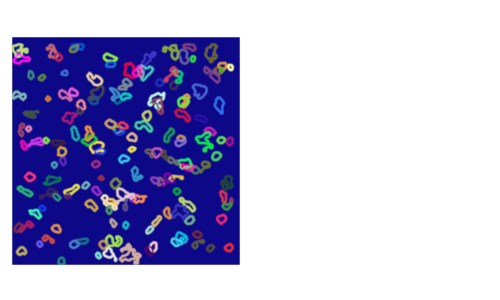

JupyterWgpuCanvas()

In [4]:
# img and contour plot
plot = GridPlot(shape=(1, 2))

data = np.ones(shape=(175, 175))

line_collection = LineCollection(data=contours, z_position=[[1]] * len(contours), colors=colors.tolist())
plot[0, 0].add_graphic(line_collection)

img = ImageGraphic(data=data)
plot[0, 0].add_graphic(img)


temporal_coll = LineCollection(data=temporal, colors=colors.tolist())
plot[0, 1].add_graphic(temporal_coll)

plot.show()

In [16]:
line_collection._world_object.parent

# you need to run this to make the stacked lineplot visible, it's easier in the latest master with camera auto-scaling

In [5]:
plot[0, 1].controller.distance = 0
auto_scale(plot[0, 1])

In [6]:
white = list()
for contour in line_collection:
    white.append(np.ones(shape=contour.colors.shape))

In [7]:
white_temporal = np.ones((len(contours), 4)).astype(np.float32)

In [8]:
from typing import *

In [9]:
def indices_mapper(target: Any, indices: np.array) -> int:
    # calculate coms of line collection 
    
    coms = list()

    for contour in target.data:
        coors = contour.data[~np.isnan(contour.data).any(axis=1)]
        com = coors.mean(axis=0)
        coms.append(com)

    # euclidean distance to find closest index of com 
    indices = np.append(indices, [0])
    
    ix = np.linalg.norm((coms - indices), axis=1).argsort()[0] 
    
    #return that index to set feature 
    return ix

In [11]:
# until we create an event "color-changed" (and for other graphic features)
# later we can just use the "color-changed" event from contour to change the lineplot or heatmap etc.
def indices_mapper_temporal(target, indices):
    # global since we don't have something like "color changed"
    # as an event which we can used for stakced line plots
    global contours
    coms = list()

    for contour in contours:
        coors = contour[~np.isnan(contour.data).any(axis=1)]
        com = coors.mean(axis=0)
        coms.append(com)
        
    ix = np.linalg.norm((np.array(coms) - np.array(indices)), axis=1).argsort()[0]
    print(ix)
    
    #return that index to set feature 
    return ix

In [12]:
img.link(event_type="click", target=line_collection, feature="colors", new_data=white, indices_mapper=indices_mapper)

In [13]:
img.link(event_type="click", target=temporal_coll, feature="colors", new_data=white_temporal, indices_mapper=indices_mapper_temporal)